局所線形埋め込み法について
=====
この記事は以下の二つの文献を参考に書かれています  
カーネル多変量解析，赤穂昭太郎，2008  
Saul, L. K., & Roweis, S. T. (2001). An introduction to locally linear embedding. Available from https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf


今回は局所線形埋め込み法のアルゴリズムの詳細を記述していきます．  
主に「カーネル多変量解析」と同じ順番で解説・実装していきます

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

データを構成します．  
今回は「カーネル多変量解析」と同じようなスイスロールのようなデータを構成しましょう

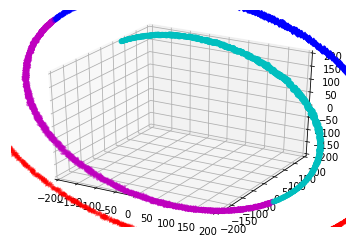

In [2]:
np.random.seed(seed=0)
sampleSize = 5000
R = 24.0
initialTheta = 12.0
thetaRange = 12.0
nLabel = 4
markers = ['o', 'X', 'd', '*', '>', '8', 's', 'p']
colors =['c','m','b','r','y','g','k']
theta = thetaRange * np.random.rand(sampleSize)+initialTheta
y = 3.0 * (np.random.randn(sampleSize) - 0.5)
Xs = []
Ys = []
Zs = []
Labels = []
X = []
for i in range(nLabel):
    Xs += [[]]
    Ys += [[]]
    Zs += [[]]
for i in range(sampleSize):
    knd = int(float(nLabel)*((theta[i]-initialTheta) / thetaRange))
    Xs[knd] += [R*theta[i]  * np.sin(theta[i])]
    Ys[knd] += [y[i]]
    Zs[knd] += [R*theta[i]  * np.cos(theta[i])]
    Labels += [knd]
    X += [[R*theta[i]  * np.sin(theta[i]), y[i],R*theta[i]* np.cos(theta[i]) ]]
Labels = np.array(Labels)
X = np.array(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i in range(nLabel):
    ax.scatter(Xs[i], Ys[i], Zs[i], marker = markers[i], color = colors[i])
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)

plt.show()

ここからが局所線形埋め込み法の実装になります．  
データ$X= (x_1, x_2, \cdots, x_n)$が与えられたとき，それぞれのデータ$x_i$の近傍の点を求めます

今回は近傍の決定法として，最も近い$K$個の点を近傍とする．  
(半径$r$以内の点を近傍とすることもある)

In [3]:
from scipy.spatial.distance import pdist,squareform

K = 9
mat_sq_dists = squareform(pdist(X, 'sqeuclidean'))
sort_dist = np.sort(mat_sq_dists, axis = 1)
boundaryDist = np.sort(mat_sq_dists, axis = 1)[:, K].reshape(sampleSize, 1)
print("近傍に入っている点の個数の平均値:"+str((np.sum(mat_sq_dists<=boundaryDist,axis = 1)-1.0).mean()))

近傍に入っている点の個数の平均値:9.0


例：$x_5$の近傍$N_5$は次のように書くと取り出すことができる

N_5の近傍：[[ 370.43700207    2.41431956  295.60210362]
 [ 376.50708276   -6.27668846  288.60143802]
 [ 370.33909388   -5.25680945  295.71277949]
 [ 366.04862915   -2.18326335  300.49539569]
 [ 368.80388222   -7.13018436  297.43913578]
 [ 372.73190552   -5.0731411   292.98782393]
 [ 373.7587354    -1.44355564  291.8054465 ]
 [ 373.69527005   -5.28750485  291.87875517]
 [ 374.40131523    1.23190611  291.06149162]]


(-200, 200)

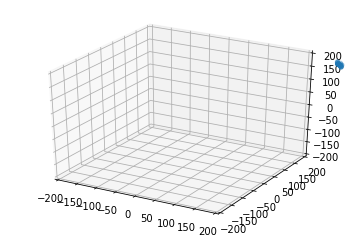

In [4]:
distFilter = (mat_sq_dists <= boundaryDist)&(mat_sq_dists != 0)
print("N_5の近傍："+str(X[distFilter[5]]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[distFilter[5]][:,0], X[distFilter[5]][:,1], X[distFilter[5]][:,2])
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-200,200)

# Step1
まず，各$x_i$について，次の最適化問題を解くことにより$W_{ij}$を決定していく  
$ \min_{W_i} || x_i - \sum_{j \in N_i } W_{ij} x_j ||^2$ subject to $W_i {\bf 1}  = 1, \forall j \not \in N_i\ ( W_{ij} = 0 )$  
  
  
この式は$C_{jk} = (x_i-x_j)^T (x_i - x_k)$とおくと  
$ \min_{W_i} W_i C W_i^T$ subject to $W_i {\bf 1}  = 1$  
と書くことができることを利用すると  
この最適化問題はラグランジュの未定乗数法により，
$$ w_{ij} = \frac {\sum_{k} C_{jk}^{-1}} {\sum_{lm} C_{lm}^{-1}}$$  
となることがわかる

しかし，実用上，$\sum_{k \in N_i} C_{jk} W_{ik} = 1$を満たす$W_{ik}$を求めたのち，$W_i {\bf 1}  = 1$を満たすように正規化するほうが効率的である  

上記の方法で求めた$W_i$が最適化問題の解であることは，KKT条件を満たすことより局所的最小，制約条件を満たす$W_i$の定義域が凸集合であり，$W_i C W_i^T$が凸関数であることより大域的最小，といったように確認できる  

ただし，Cは半正定値であり，退化してしまっている可能性があるので，計算する前に次のような処理をする
$$C = C + \left ( \frac {\Delta^2} {K} \right ) I$$  
$\Delta^2$は$C$の対角成分と比較して十分小さい値をとる．$K$は近傍に入っている点の個数，$I$は単位行列である

In [5]:
W = np.zeros((sampleSize, sampleSize))
delta = 0.00001
for i in range(sampleSize):
    Ni_xi = X[distFilter[i],:] - X[i,:]
    ln = int(np.sum(distFilter[i]))
    C = np.zeros((ln,ln))
    for j in range(ln):
        for k in range(ln):
            C[j][k] = np.dot( Ni_xi[j].T , Ni_xi[k])
    w = np.linalg.solve(C + delta * np.identity(len(C))/float(len(C)), np.ones(len(C)))
    W[i][distFilter[i]] = w/np.sum(w)

# Step 2
$W$を求めることができたので，次の段階に移る  
各$x_i$が，$L$次元ベクトル$\beta_i$と表せたとしよう．  
このとき，$B = (\beta_1,  \beta_2, \cdots, \beta_n)$は次のような関係を持つことが望まれる．  
$$
\min_{\beta} \sum_{i=1}^n || \beta_i - \sum_{j \in N_i} W_{ij} \beta_j  ||^2 \ \ \mbox{subject to} \ \ \frac {1} {n} B B^T = I
$$
この式は次のように展開できる  
$$
\begin{align}
\sum_{i=1}^n || \beta_i - \sum_{j \in N_i} W_{ij} \beta_j  ||^2 &=& \sum_{i=1}^n || B e_i - B W_i^T   ||^2\\
&=& \sum_{i=1}^n  ( e_i -  W_i^T)^T B^T B  ( e_i -  W_i^T) \\
&=& \sum_{i=1}^n  {\rm tr}\left ( (e_i -  W_i^T)^T B^T B  ( e_i -  W_i^T) \right )\\
&=& \sum_{i=1}^n  {\rm tr}\left (  B  ( e_i -  W_i^T) (e_i -  W_i^T)^T B^T \right )\\
&=&   {\rm tr}\left (  B  \left (\sum_{i=1}^n e_i e_i^T +  W_i^T W_i -  (e_i W_i)^T  -  e_i W_i \right ) B^T \right )\\
&=&   {\rm tr}\left (  B  \left (I +  W^T W -  W^T  -  W \right ) B^T \right )\\
&=&   {\rm tr}\left (  B  \left (I   -  W \right )^T  \left (I   -  W \right )  B^T \right )\\
\end{align}
$$
ラグランジュの未定乗数法により解くことを考えると，ラグランジュ関数$L(B, \lambda )$は
$$
L(B, \lambda ) := {\rm tr}\left (  B  \left (I   -  W \right )^T  \left (I   -  W \right ) B^T - \Lambda  (\frac {1} {n} B B^T - I ) \right )
$$
ただし，$\Lambda$は
$$
\Lambda = \left[\begin{array}{ccc}
            \lambda_1 & \ & \ & O\\
            \ & \lambda_2 & \ &  \\
            \ & \  & \ddots &  \\
            O & \ & \ &\lambda_L
        \end{array}\right] \quad
$$
$B$に関する微分を考えると(注:${\rm tr}(X^TCX)$の$X$についての微分は$(C+C^T)X$)
$$
\nabla_{B} L(B, \lambda ) = {\bf 0} \to   \left (I   -  W \right )^T  \left (I   -  W \right ) B^T = \Lambda  B^T
$$
以上から，$B = (\beta_1,  \beta_2, \cdots, \beta_n)$は$\left (I   -  W \right )^T  \left (I   -  W \right )$の固有値を小さいほうから$L$個とり，それに対応する長さ$n$の$L$個の固有ベクトルを$L$行に並べたものであることがわかる．なぜならば，$\left (I   -  W \right )^T  \left (I   -  W \right )$は実対称行列であることから異なる固有値の固有ベクトルは互いに直交しあうことにより，$\frac {1} {n} B B^T = I$が自動的に導かれる．また，最小化問題であるので，$\left (I   -  W \right )^T  \left (I   -  W \right )$の小さい順にならべたとき前から$L$個の固有値に対応する固有ベクトルがこの最小化問題の解であることが理解できる．  
  
  
ただし，Step1の時と同様に自明な解${\bf 1}$を除くこと

In [6]:
L = 2
eg, vs = np.linalg.eigh(np.dot(np.eye(sampleSize)-W.T, np.eye(sampleSize)-W))
##
indx = eg>0.000000000001
for i in range(sampleSize):
    print(eg[i])
cnt = 0
indx[0] = False
for i in range(sampleSize-1):
    if cnt<L and indx[i+1]:
        cnt = cnt + 1
    else:
        indx[i+1] = False
##vs[indx]
#B = sampleSize * vs[:,indx]

B = sampleSize * vs[:,1:1+L]


-6.29213111063e-15
-7.35249121213e-16
-6.64213982306e-16
-5.82975017262e-16
-5.73698244538e-16
-5.11807752262e-16
-4.45053459521e-16
-3.47708004215e-16
-3.36555805623e-16
-2.68651785637e-16
-2.58883373874e-16
-2.33071580122e-16
-1.18844344026e-16
-7.12159316136e-17
-3.78195992106e-17
2.77178358046e-17
2.99037117142e-17
8.43669941792e-17
1.48003303163e-16
1.83552188621e-16
2.45087452226e-16
2.80498553036e-16
2.99768165153e-16
3.79215503706e-16
4.25888167925e-16
4.82982473919e-16
4.84396699401e-16
5.38279298358e-16
5.5295261748e-16
6.52745259189e-16
7.04365275469e-16
8.39216604009e-16
9.26289318715e-16
1.01214262016e-15
1.52909655351e-15
2.66311307937e-15
4.17745157612e-15
7.14166377763e-15
1.61142729155e-14
1.75997601392e-14
2.87690084007e-14
3.37998052988e-14
7.47238642943e-14
1.29093513178e-13
1.30558514502e-13
1.5859216051e-13
2.61908883559e-13
2.92668553521e-13
3.95666030442e-13
4.11898515483e-13
5.42861425939e-13
6.35642212138e-13
7.52741086727e-13
1.01097463082e-12
1.01990873085e-

2.84496202738
2.84524221423
2.84568720863
2.84626016192
2.84839147881
2.84849817778
2.84895725808
2.84940253421
2.84992319994
2.8533943617
2.85394096599
2.85596008161
2.85602643105
2.86154567325
2.86193864245
2.86225533455
2.86340971324
2.86355179776
2.86512460278
2.86779646472
2.86870139162
2.86898890063
2.8725364945
2.87273255809
2.87645436368
2.87789574728
2.87816737574
2.88084136319
2.88570872664
2.88643237196
2.88647581883
2.88857334128
2.89308941935
2.89373001658
2.89645870987
2.89765968979
2.89945203147
2.90003490477
2.90289706629
2.90430681242
2.9090262452
2.90950556832
2.90999547365
2.91256940073
2.91538611293
2.92290123077
2.92406366663
2.9254576301
2.92739048633
2.92817247781
2.92847753785
2.93065780265
2.9339845513
2.9420167831
2.94272905982
2.9451269841
2.94871836885
2.95182084071
2.95202481603
2.95537603919
2.95549734488
2.95955032988
2.96104292072
2.96203361643
2.96616388564
2.96709756639
2.96748391981
2.97021046398
2.97477886406
2.97547695497
2.9803294888
2.98134820137


$B$が求まったので，さっそくグラフで描画してみよう

In [19]:
B = sampleSize * vs[:,7:7+L]

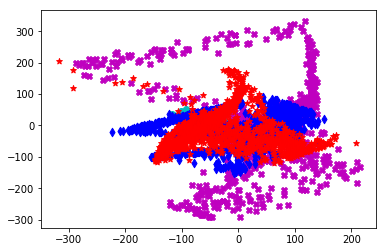

In [20]:

for i in range(nLabel):
    plt.scatter(B[Labels==i,0],B[Labels==i,1], color = colors[i], marker = markers[i])
##print(B[:,0])